#### This notebook will use a generalized Pareto distribution to demonstrate the property of non-convergence of the mean, depending on the shape parameter ξ

#### The distribution will have a gamma core and Pareto tail, and if the user picks ξ to be greater or equal than 1, a running mean will demonstrate the non-convergence property

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#adjustable parameters
XI = 1.1 # tail fatness (ξ)
N = 200_000 # total samples for running average

In [6]:
#fixed parameters
P_TAIL = 0.05  # probability of routing to the tail
K, THETA = 5.0, 2.0  # Gamma core

In [8]:
## Sample the core distribution to estimate threshold and set a smooth scale for the tail (GPD)
rng = np.random.default_rng(20250823)

core_sample = rng.gamma(shape=K, scale=THETA, size=400_000) #400k samples
u = float(np.quantile(core_sample, 0.95)) #threhold for tail set the same as P_TAIL
exceed = core_sample[core_sample > u] - u #exceedance distribution
beta = float(exceed.mean()) if exceed.size > 0 else 1.0 #matching the exeedence scale to GPD

In [10]:
#generate pure GPD sample using the inverse CDF
def rvs_gpd(n, xi, beta, rng):
    u0 = rng.uniform(size=n)
    if xi == 0:
        return -beta * np.log(1.0 - u0)
    return (beta/xi) * ((1.0 - u0) ** (-xi) - 1.0)

#generate a mixed sample with a gamma core and GPD tail
def sample_gamma_gpd(n, p_tail, xi, beta, u, k, theta, rng):
    flags = rng.uniform(size=n) < p_tail
    x = rng.gamma(shape=k, scale=theta, size=n)
    x = np.minimum(x, u)  # keep core at/below threshold
    m = int(flags.sum())
    if m > 0:
        x[flags] = u + rvs_gpd(m, xi=xi, beta=beta, rng=rng)
    return x

In [12]:
mean_infinite = (XI >= 1.0) and (P_TAIL > 0.0)
if mean_infinite:
    print(f"You picked ξ={XI}, which is greater or equal to 1 --> the mean will NOT converge.")
else:
    print(f"You picked ξ={XI}, which is less than 1 --> the mean WILL converge.")

You picked ξ=1.1, which is greater or equal to 1 --> the mean will NOT converge.


In [14]:
#generate N samples
x = sample_gamma_gpd(N, P_TAIL, XI, beta, u, K, THETA, rng)

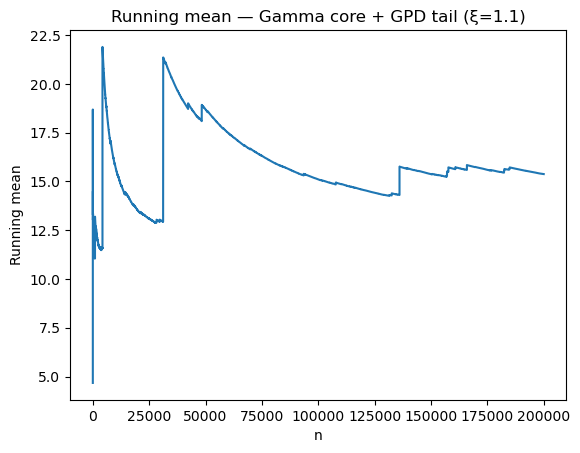

In [16]:
#plot running mean to show converge/not-converge
rm = np.cumsum(x) / np.arange(1, x.size + 1)
plt.figure()
plt.plot(np.arange(1, rm.size + 1), rm)
plt.xlabel("n")
plt.ylabel("Running mean")
plt.title(f"Running mean — Gamma core + GPD tail (ξ={XI})")
plt.show()